In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import streamlit as st


In [2]:
# Load your dataset (assuming df is your DataFrame)
df = pd.read_csv(r"C:\Users\irind\Downloads\DL_Dataset\female_players.csv")

# List of features for LSTM
features = ["overall", "potential", "pace", "shooting", "passing"]
target = "value_eur"  # Your target column (value_eur in this case)

# Drop rows with missing target values
df = df.dropna(subset=[target])

# Fill missing feature values with mean of the column
df[features] = df[features].fillna(df[features].mean())

# Normalize the features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Apply log transformation to target variable (if applicable)
df["value_eur_log"] = np.log1p(df["value_eur"])  # Use log1p to handle zero values

# Display the first few rows of the preprocessed data
df.head()


C:\Users\irind\AppData\Local\Temp\ipykernel_32124\898331488.py:2: DtypeWarning: Columns (17,20,21,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"C:\Users\irind\Downloads\DL_Dataset\female_players.csv")


,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,value_eur_log
0,227125,/player/227125/sam-kerr/230009,23,9,2023-01-13,S. Kerr,Samantha May Kerr,ST,1.000000,0.903226,...,62+3,64+3,61+3,58+3,58+3,58+3,61+3,20+3,https://cdn.sofifa.net/players/227/125/23_120.png,18.717075
1,227316,/player/227316/wendie-renard/230009,23,9,2023-01-13,W. Renard,Wéndèleine Thérèse Renard,CB,1.000000,0.903226,...,87+3,80+3,82+3,91,91,91,82+3,21+3,https://cdn.sofifa.net/players/227/316/23_120.png,18.309749
3,227310,/player/227310/ada-hegerberg/230009,23,9,2023-01-13,A. Hegerberg,Ada Martine Stolsmo Hegerberg,ST,0.970588,0.903226,...,61+3,63+3,60+3,56+3,56+3,56+3,60+3,20+3,https://cdn.sofifa.net/players/227/310/23_120.png,18.778355
5,245802,/player/245802/beth-mead/230009,23,9,2023-01-13,B. Mead,Bethany Jane Mead,"RW, LW, RM",0.941176,0.838710,...,76+3,80+3,78+3,70+3,70+3,70+3,78+3,22+3,https://cdn.sofifa.net/players/245/802/23_120.png,18.515991
6,246272,/player/246272/marie-katoto/230009,23,9,2023-01-13,M. Katoto,Marie-Antoinette Oda Katoto,ST,0.941176,0.967742,...,60+3,63+3,60+3,54+3,54+3,54+3,60+3,20+3,https://cdn.sofifa.net/players/246/272/23_120.png,18.822807


In [3]:
# Create sequences of features for LSTM input
sequence_length = 5  # Number of time steps

def create_sequences(data, features, seq_len):
    sequences, labels = [], []
    for i in range(len(data) - seq_len):
        seq = data.iloc[i:i + seq_len][features].values
        label = data.iloc[i + seq_len]["value_eur_log"]  # Using log-transformed target
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Generate sequences and labels
lstm_sequences, lstm_labels = create_sequences(df, features, sequence_length)

# Split into training and test sets
from sklearn.model_selection import train_test_split
lstm_sequences_train, lstm_sequences_test, y_train, y_test = train_test_split(lstm_sequences, lstm_labels, test_size=0.2, random_state=42)

# Display the shapes of the sequences
print("Training data shape:", lstm_sequences_train.shape)
print("Test data shape:", lstm_sequences_test.shape)


Training data shape: (3860, 5, 5)
Test data shape: (966, 5, 5)


In [4]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(lstm_sequences_train.shape[1], lstm_sequences_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output for regression

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Model summary
model.summary()


C:\Users\irind\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 165.9329 - mae: 11.6960 - val_loss: 1.3252 - val_mae: 0.9081
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2263 - mae: 1.1937 - val_loss: 1.1037 - val_mae: 0.8123
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0556 - mae: 1.1335 - val_loss: 0.9377 - val_mae: 0.7016
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6884 - mae: 1.0182 - val_loss: 0.8930 - val_mae: 0.6424
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7076 - mae: 1.0149 - val_loss: 0.8684 - val_mae: 0.6150
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7515 - mae: 1.0271 - val_loss: 0.8376 - val_mae: 0.5975
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5650 - mae: 0.9641 - val_loss: 0.7608 - val_mae: 0.5590
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4212 - mae: 0.9155 - val_loss: 0.7228 - val_mae: 0.5339
Epoch 9/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5298 - ma

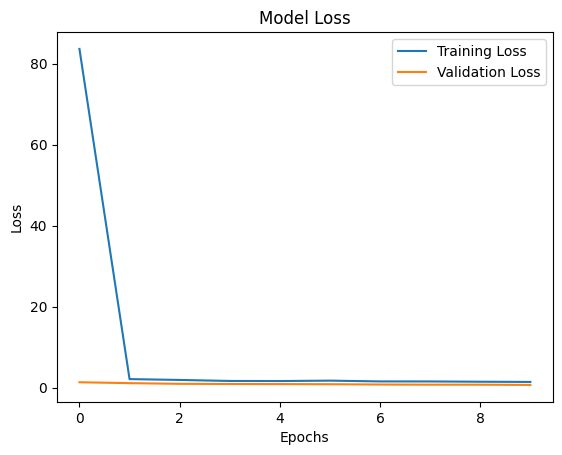

In [5]:
# Train the model
history = model.fit(
    lstm_sequences_train,
    y_train,
    validation_split=0.2,
    epochs=10,  # Adjust epochs as needed
    batch_size=32
)

# Plot training history (Loss vs Epochs)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
# Predict on the test set
predictions = model.predict(lstm_sequences_test)

# Reverse the log transformation on predicted and actual values
predicted_values = np.expm1(predictions.flatten())  # Reverse log transformation
actual_values = np.expm1(y_test.flatten())  # Reverse log transformation

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    "Predicted Value": predicted_values,
    "Actual Value": actual_values
})

# Display the first few rows of the DataFrame
import IPython.display as display
display.display(results_df)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


,Predicted Value,Actual Value
0,30950332.00,56000000.0
1,54508208.00,66500000.0
2,3919241.25,2400000.0
3,9004019.00,12000000.0
4,3759376.00,2000000.0
...,...,...
961,4926878.00,2500000.0
962,3531822.50,1100000.0
963,4716011.50,5500000.0
964,5304620.00,4200000.0
